In [ ]:
#@title 0. Setup

!mkdir -p /content/extracted
!unzip -o /content/dataset224_250.zip -d /content/extracted

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

from PIL import Image
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

data_root = "/content/extracted"
num_classes = 4  
IMG_SIZE = 224

Archive:  /content/dataset224_250.zip
   creating: /content/extracted/0/
   creating: /content/extracted/1/
   creating: /content/extracted/2/
   creating: /content/extracted/3/
  inflating: /content/extracted/2/2_0211.png  
  inflating: /content/extracted/2/2_0107.png  
  inflating: /content/extracted/2/2_0161.png  
  inflating: /content/extracted/2/2_0159.png  
  inflating: /content/extracted/2/2_0021.png  
  inflating: /content/extracted/2/2_0065.png  
  inflating: /content/extracted/2/2_0243.png  
  inflating: /content/extracted/2/2_0072.png  
  inflating: /content/extracted/2/2_0148.png  
  inflating: /content/extracted/2/2_0002.png  
  inflating: /content/extracted/2/2_0008.png  
  inflating: /content/extracted/2/2_0249.png  
  inflating: /content/extracted/2/2_0168.png  
  inflating: /content/extracted/2/2_0151.png  
  inflating: /content/extracted/2/2_0132.png  
  inflating: /content/extracted/2/2_0062.png  
  inflating: /content/extracted/2/2_0092.png  
  inflating: /content/e

In [ ]:
#@title 1. PCB corrosion pipeline -> mask_clean (0/1) + inner_copper (0/1)

def pcb_corrosion_mask(img_bgr, debug=False):
    pcb_bgr = img_bgr.copy()
    gray = cv2.cvtColor(pcb_bgr, cv2.COLOR_BGR2GRAY)
    H_img, W_img = gray.shape[:2]

    hsv = cv2.cvtColor(pcb_bgr, cv2.COLOR_BGR2HSV)
    Hc, S, V = cv2.split(hsv)

    _, board_mask0 = cv2.threshold(S, 25, 255, cv2.THRESH_BINARY)
    kernel_board = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
    board_mask = cv2.morphologyEx(board_mask0, cv2.MORPH_CLOSE,
                                  kernel_board, iterations=1)
    board_mask = cv2.morphologyEx(board_mask, cv2.MORPH_OPEN,
                                  kernel_board, iterations=1)

    lab = cv2.cvtColor(pcb_bgr, cv2.COLOR_BGR2LAB)
    L, A, B = cv2.split(lab)

    L_f = L.astype(np.float32)
    bg = cv2.GaussianBlur(L_f, (201, 201), 0)
    ratio = cv2.divide(L_f, bg + 1)
    ratio_n = cv2.normalize(ratio, None, 0, 255,
                            cv2.NORM_MINMAX).astype(np.uint8)

    ret_L, mask_L = cv2.threshold(
        ratio_n, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )
    if ratio_n[mask_L == 255].mean() < ratio_n[mask_L == 0].mean():
        mask_L = 255 - mask_L

    mask_copper0 = cv2.bitwise_and(board_mask, mask_L)

    kernel_copper = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask_copper = cv2.morphologyEx(mask_copper0, cv2.MORPH_CLOSE,
                                   kernel_copper, iterations=1)

    kernel_roi = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    inner_copper = cv2.dilate(mask_copper, kernel_roi, iterations=1)

    sigma = 7
    ksize = int(6 * sigma + 1)
    if ksize % 2 == 0:
        ksize += 1
    blur = cv2.GaussianBlur(gray, (ksize, ksize), sigmaX=sigma)
    dark = cv2.subtract(blur, gray)
    dark_norm = cv2.normalize(dark, None, 0, 255,
                              cv2.NORM_MINMAX).astype(np.uint8)

    gray_f = gray.astype(np.float32)
    win = 9
    mean = cv2.blur(gray_f, (win, win))
    mean_sq = cv2.blur(gray_f * gray_f, (win, win))
    var = mean_sq - mean * mean
    var[var < 0] = 0
    std_local = np.sqrt(var)
    std_norm = cv2.normalize(std_local, None, 0, 255,
                             cv2.NORM_MINMAX).astype(np.uint8)

    score = cv2.addWeighted(dark_norm, 0.5, std_norm, 0.5, 0)
    score_inner = np.zeros_like(score, dtype=np.float32)
    score_inner[inner_copper == 255] = score[inner_copper == 255]

    mask_copper_bin = (mask_copper > 0).astype(np.uint8) * 255
    kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
    copper_closed = cv2.morphologyEx(mask_copper_bin, cv2.MORPH_CLOSE,
                                     kernel_close, iterations=1)
    gap_raw = cv2.subtract(copper_closed, mask_copper_bin)
    gap_raw = cv2.bitwise_and(gap_raw, inner_copper)

    h, w = score_inner.shape
    mid = h // 2
    mask_bottom = np.zeros_like(inner_copper, dtype=bool)
    mask_bottom[mid:h, :] = True

    vals_bottom = score_inner[
        (inner_copper == 255) & mask_bottom & (score_inner > 0)
    ]

    if len(vals_bottom) > 0:
        sensitivity_bottom = 0.15
        thr_bottom = np.percentile(
            vals_bottom, 100 * (1.0 - sensitivity_bottom)
        )
        mask_dark_bottom = np.zeros_like(score_inner, dtype=np.uint8)
        cond_bottom = (
            (score_inner >= thr_bottom) &
            (inner_copper == 255) &
            mask_bottom
        )
        mask_dark_bottom[cond_bottom] = 255
    else:
        mask_dark_bottom = np.zeros_like(score_inner, dtype=np.uint8)

    mask_clean = cv2.bitwise_or(gap_raw, mask_dark_bottom.astype(np.uint8))
    
    inner_copper01 = (inner_copper > 0).astype(np.uint8)
    mask_clean01 = (mask_clean > 0).astype(np.uint8)

    if debug:
        plt.figure(figsize=(10,4))
        plt.subplot(1,3,1); plt.imshow(cv2.cvtColor(pcb_bgr, cv2.COLOR_BGR2RGB)); plt.title("RGB"); plt.axis("off")
        plt.subplot(1,3,2); plt.imshow(inner_copper01, cmap="gray"); plt.title("Inner copper"); plt.axis("off")
        plt.subplot(1,3,3); plt.imshow(mask_clean01, cmap="gray"); plt.title("Corrosion mask"); plt.axis("off")
        plt.show()

    return mask_clean01, inner_copper01

Test image: /content/IMG_4396.jpg


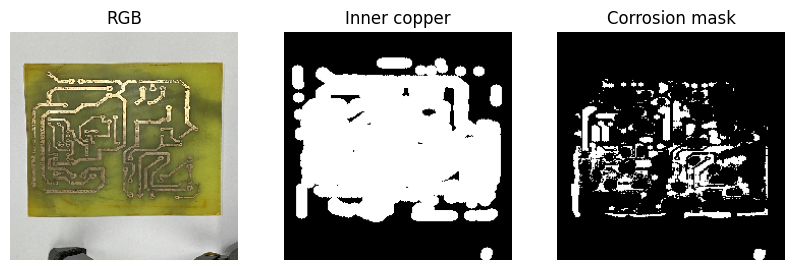

In [ ]:
#@title 1.5. Test nhanh pipeline trên 1 ảnh bất kỳ
test_path = "/content/IMG_4396.jpg"
for root, dirs, files in os.walk(data_root):
    for f in files:
        if f.lower().endswith((".png", ".jpg", ".jpeg")):
            test_path = os.path.join(root, f)
            break
    if test_path:
        break

print("Test image:", test_path)
img = cv2.imread(test_path)
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
mask_clean, inner_copper = pcb_corrosion_mask(img, debug=True)

In [ ]:
#@title 2. Dataset cho ResNet (4 kênh = RGB + corrosion mask)

class PcbPatchWithMaskDataset(Dataset):
    def __init__(self, root, img_size=224):
        self.root = root
        self.img_size = img_size

        self.samples = []
        for label_str in sorted(os.listdir(root)):
            label_dir = os.path.join(root, label_str)
            if not os.path.isdir(label_dir):
                continue
            label = int(label_str)
            for fname in os.listdir(label_dir):
                if fname.lower().endswith((".jpg", ".jpeg", ".png", ".bmp")):
                    self.samples.append((os.path.join(label_dir, fname), label))

        print("Total samples:", len(self.samples))
        self.img_transform = transforms.ToTensor()

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]

        img_bgr = cv2.imread(path)
        if img_bgr is None:
            raise FileNotFoundError(path)

        img_bgr = cv2.resize(img_bgr, (self.img_size, self.img_size),
                             interpolation=cv2.INTER_AREA)

        mask_clean01, _ = pcb_corrosion_mask(img_bgr, debug=False)  

        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(img_rgb)
        img_tensor = self.img_transform(img_pil)     

        mask_tensor = torch.from_numpy(mask_clean01).float().unsqueeze(0)  

        x_4ch = torch.cat([img_tensor, mask_tensor], dim=0)  

        return x_4ch, label

In [ ]:
#@title 3. Tạo DataLoader cho ResNet

full_dataset_cnn = PcbPatchWithMaskDataset(data_root, img_size=IMG_SIZE)

val_ratio = 0.2
val_size = int(len(full_dataset_cnn) * val_ratio)
train_size = len(full_dataset_cnn) - val_size

train_ds_cnn_raw, val_ds_cnn_raw = random_split(full_dataset_cnn,
                                                [train_size, val_size])

import torchvision.transforms.functional as TF
from torchvision.transforms import ColorJitter

class Resnet4ChWrapper(Dataset):
    def __init__(self, subset, train=True):
        self.subset = subset
        self.train = train
        if train:
            self.color_jitter = ColorJitter(
                brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05
            )
        self.mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        self.std  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        x_4ch, label = self.subset[idx]   

        if self.train:
            if torch.rand(1).item() < 0.5:
                x_4ch = torch.flip(x_4ch, dims=[2])

            if torch.rand(1).item() < 0.5:
                x_4ch = torch.flip(x_4ch, dims=[1])  

            rgb = x_4ch[:3]
            rgb = self.color_jitter(rgb)
            mask = x_4ch[3:].clone()
            x_4ch = torch.cat([rgb, mask], dim=0)

        rgb = x_4ch[:3]
        mask = x_4ch[3:].clone()
        rgb = (rgb - self.mean) / self.std
        x_4ch = torch.cat([rgb, mask], dim=0)

        return x_4ch, label

train_dataset_cnn = Resnet4ChWrapper(train_ds_cnn_raw, train=True)
val_dataset_cnn   = Resnet4ChWrapper(val_ds_cnn_raw,   train=False)

batch_size_cnn = 32

train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=batch_size_cnn,
                              shuffle=True, num_workers=2, pin_memory=True)
val_loader_cnn = DataLoader(val_dataset_cnn, batch_size=batch_size_cnn,
                            shuffle=False, num_workers=2, pin_memory=True)

Total samples: 1000


In [ ]:
#@title 4. Định nghĩa ResNet-18 nhận 4 kênh (RGB + mask)

from torchvision.models import resnet18

def create_resnet_4ch(num_classes=4, pretrained=True):
    model = resnet18(weights="IMAGENET1K_V1" if pretrained else None)

    old_conv = model.conv1
    model.conv1 = nn.Conv2d(
        in_channels=4,
        out_channels=old_conv.out_channels,
        kernel_size=old_conv.kernel_size,
        stride=old_conv.stride,
        padding=old_conv.padding,
        bias=False
    )

    with torch.no_grad():
        model.conv1.weight[:, :3] = old_conv.weight
        model.conv1.weight[:, 3:4] = old_conv.weight.mean(dim=1, keepdim=True)

    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model

model_cnn = create_resnet_4ch(num_classes=num_classes, pretrained=True).to(device)
criterion_cls = nn.CrossEntropyLoss()
optimizer_cls = torch.optim.Adam(model_cnn.parameters(), lr=1e-4)
num_epochs_cnn = 15

In [ ]:
#@title 5. Train / eval cho ResNet 4ch

def train_one_epoch_cnn(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(loader, desc="Train CNN", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total


def eval_cnn(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Val CNN", leave=False):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total

In [ ]:
#@title 6. Chạy training ResNet

best_val_acc = 0.0
history_cnn = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

for epoch in range(1, num_epochs_cnn + 1):
    print(f"\n[ResNet] Epoch {epoch}/{num_epochs_cnn}")
    train_loss, train_acc = train_one_epoch_cnn(
        model_cnn, train_loader_cnn, optimizer_cls, criterion_cls, device
    )
    val_loss, val_acc = eval_cnn(
        model_cnn, val_loader_cnn, criterion_cls, device
    )

    history_cnn["train_loss"].append(train_loss)
    history_cnn["val_loss"].append(val_loss)
    history_cnn["train_acc"].append(train_acc)
    history_cnn["val_acc"].append(val_acc)

    print(f"Train loss: {train_loss:.4f}  acc: {train_acc:.4f}")
    print(f"Val   loss: {val_loss:.4f}  acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model_cnn.state_dict(), "/content/cnn_pcb_pipeline_best.pth")
        print("=> Saved best ResNet model")


[ResNet] Epoch 1/15


Train loss: 0.8342  acc: 0.6512
Val   loss: 0.5102  acc: 0.7950
=> Saved best ResNet model

[ResNet] Epoch 2/15


Train loss: 0.3881  acc: 0.8712
Val   loss: 0.3127  acc: 0.8850
=> Saved best ResNet model

[ResNet] Epoch 3/15


Train loss: 0.2580  acc: 0.9087
Val   loss: 0.2582  acc: 0.9150
=> Saved best ResNet model

[ResNet] Epoch 4/15


Train loss: 0.1645  acc: 0.9500
Val   loss: 0.2060  acc: 0.9350
=> Saved best ResNet model

[ResNet] Epoch 5/15


Train loss: 0.1174  acc: 0.9688
Val   loss: 0.2997  acc: 0.8900

[ResNet] Epoch 6/15


Train loss: 0.0911  acc: 0.9725
Val   loss: 0.2666  acc: 0.8800

[ResNet] Epoch 7/15


Train loss: 0.0645  acc: 0.9825
Val   loss: 0.1837  acc: 0.9400
=> Saved best ResNet model

[ResNet] Epoch 8/15


Train loss: 0.0630  acc: 0.9862
Val   loss: 0.2064  acc: 0.9300

[ResNet] Epoch 9/15


Train loss: 0.0513  acc: 0.9888
Val   loss: 0.1375  acc: 0.9450
=> Saved best ResNet model

[ResNet] Epoch 10/15


Train loss: 0.0363  acc: 0.9900
Val   loss: 0.1185  acc: 0.9500
=> Saved best ResNet model

[ResNet] Epoch 11/15


Train loss: 0.0353  acc: 0.9900
Val   loss: 0.1983  acc: 0.9200

[ResNet] Epoch 12/15


Train loss: 0.0223  acc: 0.9975
Val   loss: 0.1681  acc: 0.9250

[ResNet] Epoch 13/15


Train loss: 0.0258  acc: 0.9912
Val   loss: 0.1881  acc: 0.9300

[ResNet] Epoch 14/15


Train loss: 0.0357  acc: 0.9862
Val   loss: 0.1899  acc: 0.9400

[ResNet] Epoch 15/15


Train loss: 0.0255  acc: 0.9962
Val   loss: 0.1399  acc: 0.9450


In [ ]:
#@title 7. Dataset cho UNet (RGB -> mask từ pipeline PCB)
class PcbSegDataset(Dataset):
    def __init__(self, root, img_size=224):
        self.root = root
        self.img_size = img_size

        self.samples = []
        for label_str in sorted(os.listdir(root)):
            label_dir = os.path.join(root, label_str)
            if not os.path.isdir(label_dir):
                continue
            for fname in os.listdir(label_dir):
                if fname.lower().endswith((".jpg", ".jpeg", ".png", ".bmp")):
                    self.samples.append(os.path.join(label_dir, fname))

        print("Segmentation samples:", len(self.samples))

        self.img_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5,0.5,0.5],
                                 std=[0.5,0.5,0.5]),
        ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path = self.samples[idx]

        img_bgr = cv2.imread(path)
        if img_bgr is None:
            raise FileNotFoundError(path)

        img_bgr = cv2.resize(img_bgr, (self.img_size, self.img_size),
                             interpolation=cv2.INTER_AREA)

        mask_clean01, inner_copper01 = pcb_corrosion_mask(img_bgr, debug=False)  
        mask_clean01 = mask_clean01 * inner_copper01

        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(img_rgb)
        img_tensor = self.img_transform(img_pil)   

        mask_tensor = torch.from_numpy(mask_clean01).float().unsqueeze(0)  

        return img_tensor, mask_tensor

In [ ]:
#@title 8. DataLoader cho UNet

seg_dataset = PcbSegDataset(data_root, img_size=IMG_SIZE)
pos_pixels = 0
total_pixels = 0

for i in range(len(seg_dataset)):
    _, mask = seg_dataset[i]          
    m = mask.numpy()
    pos_pixels += m.sum()
    total_pixels += m.size

pos_ratio = pos_pixels / max(total_pixels, 1)
neg_ratio = 1.0 - pos_ratio
print(f"Estimated positive pixel ratio: {pos_ratio:.6f}")

pos_weight_value = neg_ratio / max(pos_ratio, 1e-6)
pos_weight = torch.tensor(pos_weight_value, dtype=torch.float32).to(device)
print("pos_weight for BCEWithLogitsLoss:", float(pos_weight_value))

val_ratio_seg = 0.2
val_size_seg = int(len(seg_dataset) * val_ratio_seg)
train_size_seg = len(seg_dataset) - val_size_seg

seg_train_ds, seg_val_ds = random_split(seg_dataset,
                                        [train_size_seg, val_size_seg])

batch_size_seg = 8

seg_train_loader = DataLoader(seg_train_ds, batch_size=batch_size_seg,
                              shuffle=True, num_workers=2, pin_memory=True)
seg_val_loader = DataLoader(seg_val_ds, batch_size=batch_size_seg,
                            shuffle=False, num_workers=2, pin_memory=True)

Segmentation samples: 1000
Estimated positive pixel ratio: 0.051696
pos_weight for BCEWithLogitsLoss: 18.343852996826172


In [ ]:
#@title 9. Định nghĩa UNet nhỏ
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)


class UNetSmall(nn.Module):
    def __init__(self, in_ch=3, out_ch=1):
        super().__init__()
        self.down1 = DoubleConv(in_ch, 32)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(32, 64)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(64, 128)
        self.pool3 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(128, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv3 = DoubleConv(256, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv2 = DoubleConv(128, 64)
        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.conv1 = DoubleConv(64, 32)

        self.out_conv = nn.Conv2d(32, out_ch, 1)

    def forward(self, x):
        c1 = self.down1(x)
        p1 = self.pool1(c1)
        c2 = self.down2(p1)
        p2 = self.pool2(c2)
        c3 = self.down3(p2)
        p3 = self.pool3(c3)

        bn = self.bottleneck(p3)

        u3 = self.up3(bn)
        u3 = torch.cat([u3, c3], dim=1)
        c3 = self.conv3(u3)

        u2 = self.up2(c3)
        u2 = torch.cat([u2, c2], dim=1)
        c2 = self.conv2(u2)

        u1 = self.up1(c2)
        u1 = torch.cat([u1, c1], dim=1)
        c1 = self.conv1(u1)

        out = self.out_conv(c1)   # (B,1,H,W)
        return out

model_unet = UNetSmall(in_ch=3, out_ch=1).to(device)
def dice_loss(logits, targets, eps=1e-6):
    probs = torch.sigmoid(logits)
    num = 2 * (probs * targets).sum(dim=(1,2,3))
    den = (probs + targets).sum(dim=(1,2,3)) + eps
    dice = 1.0 - num / den
    return dice.mean()

bce_loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

def seg_criterion(logits, targets):
    return 0.5 * bce_loss(logits, targets) + 0.5 * dice_loss(logits, targets)

criterion_seg = seg_criterion
optimizer_seg = torch.optim.Adam(model_unet.parameters(), lr=1e-4)
num_epochs_unet = 20

In [ ]:
#@title 10. Train / eval UNet
def train_one_epoch_unet(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, total_iou, total = 0.0, 0.0, 0

    for imgs, masks in tqdm(loader, desc="Train UNet", leave=False):
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

        with torch.no_grad():
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
            intersection = (preds * masks).sum(dim=(1,2,3))
            union = ((preds + masks) > 0).float().sum(dim=(1,2,3)) + 1e-6
            iou = (intersection / union).mean().item()
            total_iou += iou * imgs.size(0)
            total += imgs.size(0)

    return running_loss / total, total_iou / total


def eval_unet(model, loader, criterion, device):
    model.eval()
    running_loss, total_iou, total = 0.0, 0.0, 0

    with torch.no_grad():
        for imgs, masks in tqdm(loader, desc="Val UNet", leave=False):
            imgs, masks = imgs.to(device), masks.to(device)

            logits = model(imgs)
            loss = criterion(logits, masks)

            running_loss += loss.item() * imgs.size(0)

            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
            intersection = (preds * masks).sum(dim=(1,2,3))
            union = ((preds + masks) > 0).float().sum(dim=(1,2,3)) + 1e-6
            iou = (intersection / union).mean().item()
            total_iou += iou * imgs.size(0)
            total += imgs.size(0)

    return running_loss / total, total_iou / total

In [ ]:
#@title 11. Chạy training UNet
best_val_iou = 0.0
history_unet = {"train_loss": [], "val_loss": [], "train_iou": [], "val_iou": []}

for epoch in range(1, num_epochs_unet + 1):
    print(f"\n[UNet] Epoch {epoch}/{num_epochs_unet}")
    train_loss, train_iou = train_one_epoch_unet(
        model_unet, seg_train_loader, optimizer_seg, criterion_seg, device
    )
    val_loss, val_iou = eval_unet(
        model_unet, seg_val_loader, criterion_seg, device
    )

    history_unet["train_loss"].append(train_loss)
    history_unet["val_loss"].append(val_loss)
    history_unet["train_iou"].append(train_iou)
    history_unet["val_iou"].append(val_iou)

    print(f"Train loss: {train_loss:.4f}  IoU: {train_iou:.4f}")
    print(f"Val   loss: {val_loss:.4f}  IoU: {val_iou:.4f}")

    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save(model_unet.state_dict(), "/content/unet_pcb_pipeline_best.pth")
        print("=> Saved best UNet model")


[UNet] Epoch 1/20


Train loss: 0.9201  IoU: 0.1205
Val   loss: 0.8350  IoU: 0.1913
=> Saved best UNet model

[UNet] Epoch 2/20


Train loss: 0.8382  IoU: 0.1877
Val   loss: 0.8049  IoU: 0.2320
=> Saved best UNet model

[UNet] Epoch 3/20


Train loss: 0.8068  IoU: 0.2147
Val   loss: 0.7738  IoU: 0.2455
=> Saved best UNet model

[UNet] Epoch 4/20


Train loss: 0.7831  IoU: 0.2321
Val   loss: 0.7516  IoU: 0.2604
=> Saved best UNet model

[UNet] Epoch 5/20


Train loss: 0.7596  IoU: 0.2425
Val   loss: 0.7353  IoU: 0.2525

[UNet] Epoch 6/20


Train loss: 0.7386  IoU: 0.2536
Val   loss: 0.7218  IoU: 0.2663
=> Saved best UNet model

[UNet] Epoch 7/20


Train loss: 0.7180  IoU: 0.2668
Val   loss: 0.6973  IoU: 0.2926
=> Saved best UNet model

[UNet] Epoch 8/20


Train loss: 0.7024  IoU: 0.2744
Val   loss: 0.7001  IoU: 0.2471

[UNet] Epoch 9/20


Train loss: 0.6876  IoU: 0.2796
Val   loss: 0.6856  IoU: 0.2672

[UNet] Epoch 10/20


Train loss: 0.6638  IoU: 0.3002
Val   loss: 0.6397  IoU: 0.3107
=> Saved best UNet model

[UNet] Epoch 11/20


Train loss: 0.6448  IoU: 0.3071
Val   loss: 0.6211  IoU: 0.3477
=> Saved best UNet model

[UNet] Epoch 12/20


Train loss: 0.6322  IoU: 0.3095
Val   loss: 0.6384  IoU: 0.3014

[UNet] Epoch 13/20


Train loss: 0.6121  IoU: 0.3272
Val   loss: 0.5996  IoU: 0.3145

[UNet] Epoch 14/20


Train loss: 0.6012  IoU: 0.3300
Val   loss: 0.5936  IoU: 0.3358

[UNet] Epoch 15/20


Train loss: 0.5881  IoU: 0.3373
Val   loss: 0.5932  IoU: 0.3144

[UNet] Epoch 16/20


Train loss: 0.5780  IoU: 0.3416
Val   loss: 0.6235  IoU: 0.3771
=> Saved best UNet model

[UNet] Epoch 17/20


Train loss: 0.5642  IoU: 0.3511
Val   loss: 0.5987  IoU: 0.2917

[UNet] Epoch 18/20


Train loss: 0.5478  IoU: 0.3601
Val   loss: 0.5607  IoU: 0.3485

[UNet] Epoch 19/20


Train loss: 0.5335  IoU: 0.3709
Val   loss: 0.5612  IoU: 0.3543

[UNet] Epoch 20/20


Train loss: 0.5206  IoU: 0.3764
Val   loss: 0.5487  IoU: 0.3570


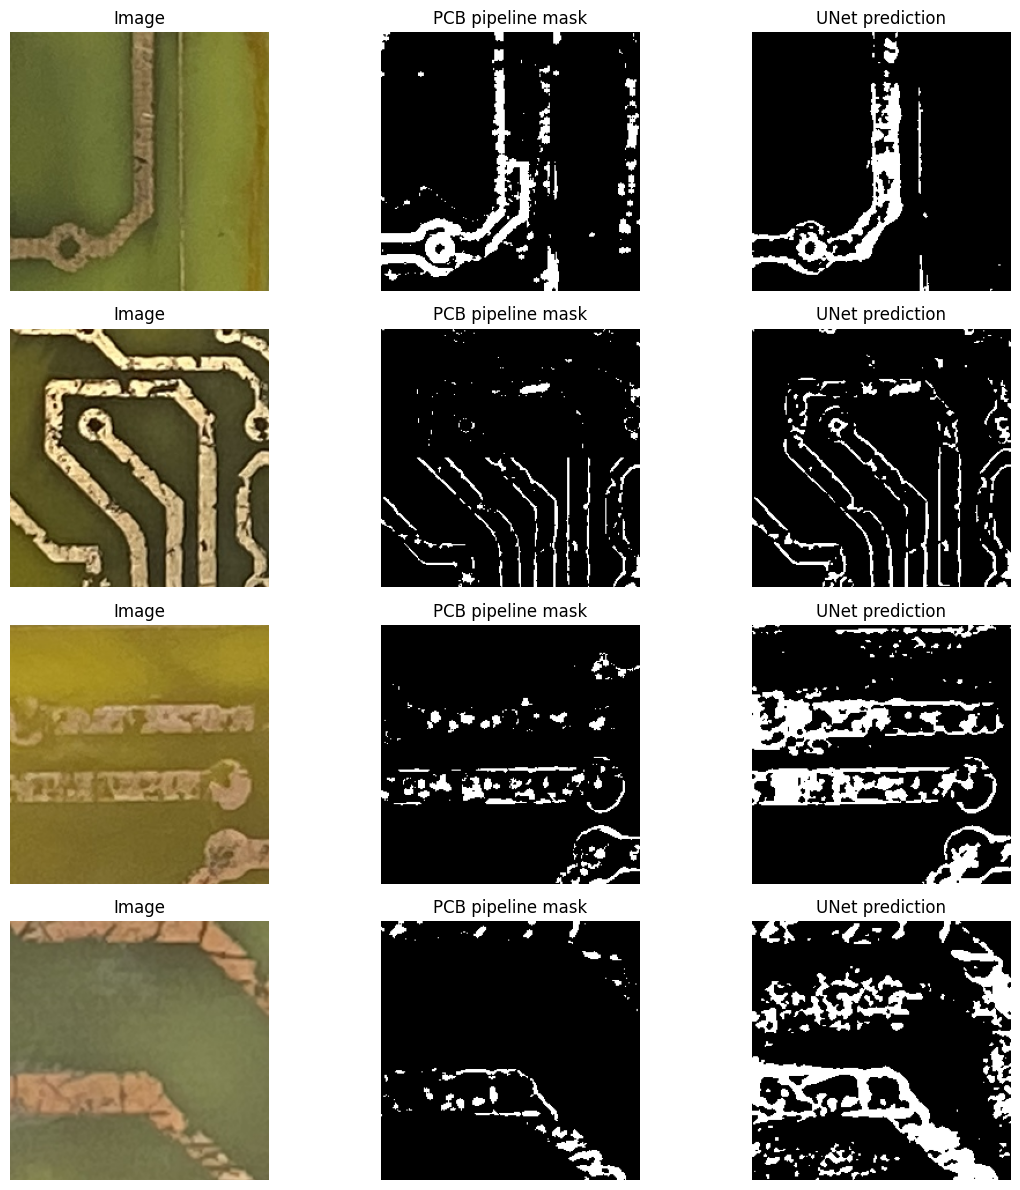

In [ ]:
#@title 12. Visualize vài prediction của UNet
model_unet.eval()

def denorm(img_tensor):
    img = img_tensor.clone()
    img = img * 0.5 + 0.5
    return img.clamp(0,1)

imgs, masks = next(iter(seg_val_loader))
imgs = imgs.to(device)
masks = masks.to(device)

with torch.no_grad():
    logits = model_unet(imgs)
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float()

imgs = denorm(imgs.cpu())
masks = masks.cpu()
preds = preds.cpu()

n_show = min(4, imgs.size(0))
plt.figure(figsize=(12, 3*n_show))

for i in range(n_show):
    plt.subplot(n_show, 3, 3*i+1)
    plt.imshow(np.transpose(imgs[i].numpy(), (1,2,0)))
    plt.title("Image"); plt.axis("off")

    plt.subplot(n_show, 3, 3*i+2)
    plt.imshow(masks[i,0].numpy(), cmap="gray")
    plt.title("PCB pipeline mask"); plt.axis("off")

    plt.subplot(n_show, 3, 3*i+3)
    plt.imshow(preds[i,0].numpy(), cmap="gray")
    plt.title("UNet prediction"); plt.axis("off")

plt.tight_layout()
plt.show()

Upload a full PCB image...


Saving IMG_4396.jpg to IMG_4396 (4).jpg
Original full image: (1400, 1050, 3)
Cropped board shape: (996, 963, 3)


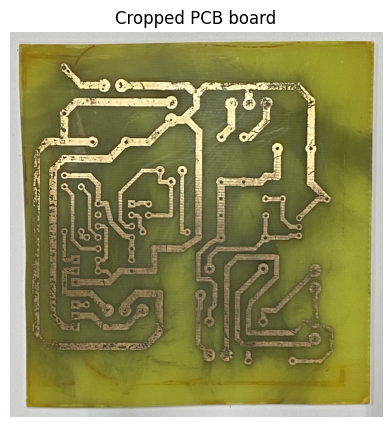

Loaded CNN checkpoint: /content/cnn_pcb_pipeline_best.pth
Loaded UNet checkpoint: /content/unet_pcb_pipeline_best.pth


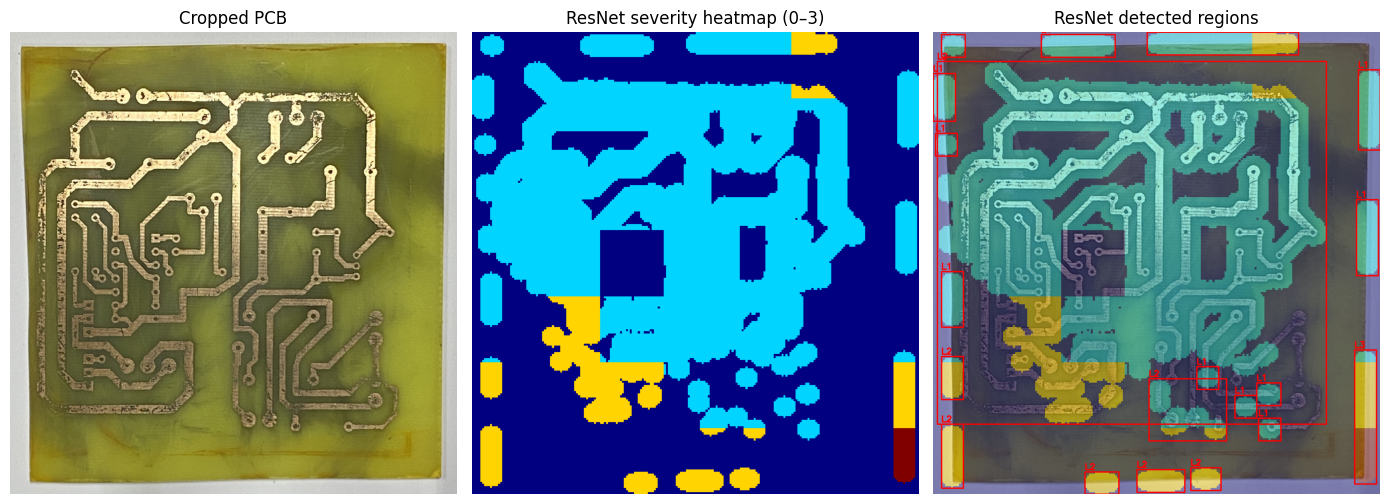

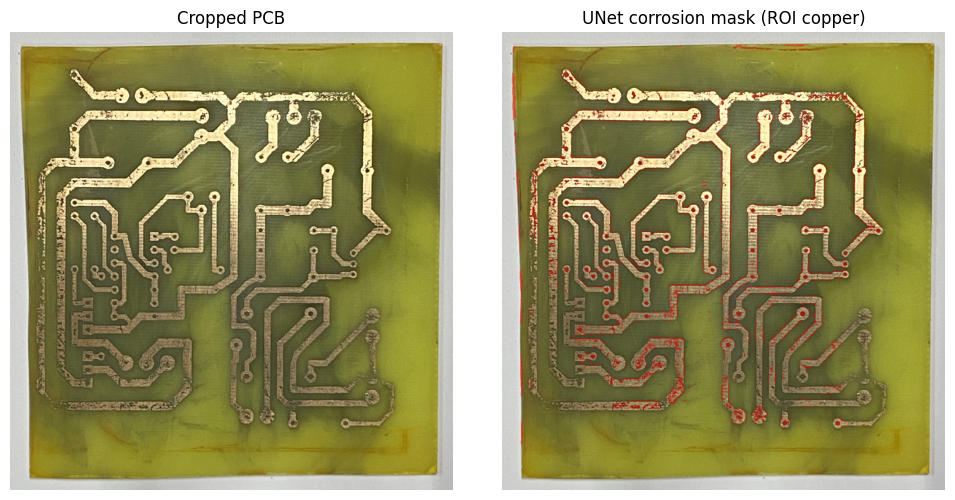


UNet corrosion coverage in copper ROI: 8.02%
Estimated global severity level (0–3) from UNet: 3


In [ ]:
#@title 13. Visualize corrosion & severity

from google.colab import files
print("Upload a full PCB image...")
uploaded = files.upload()
full_img_path = list(uploaded.keys())[0]

full_bgr = cv2.imread(full_img_path)
if full_bgr is None:
    raise FileNotFoundError(full_img_path)

max_side = 1400
H0, W0 = full_bgr.shape[:2]
scale = min(max_side / max(H0, W0), 1.0)
if scale < 1.0:
    full_bgr = cv2.resize(full_bgr, (int(W0*scale), int(H0*scale)),
                          interpolation=cv2.INTER_AREA)

print("Original full image:", full_bgr.shape)

hsv_full = cv2.cvtColor(full_bgr, cv2.COLOR_BGR2HSV)
S_full = hsv_full[:, :, 1]
_, board_mask0 = cv2.threshold(S_full, 25, 255, cv2.THRESH_BINARY)

kernel_board = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
board_mask = cv2.morphologyEx(board_mask0, cv2.MORPH_CLOSE, kernel_board, iterations=1)
board_mask = cv2.morphologyEx(board_mask, cv2.MORPH_OPEN,  kernel_board, iterations=1)

contours, _ = cv2.findContours(board_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if len(contours) == 0:
    print("WARNING: cannot find PCB board; using full image.")
    board_bgr = full_bgr.copy()
    x0 = y0 = 0
else:
    max_cnt = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(max_cnt)
    pad = int(0.02 * min(full_bgr.shape[0], full_bgr.shape[1]))
    x0 = max(x - pad, 0)
    y0 = max(y - pad, 0)
    x1 = min(x + w + pad, full_bgr.shape[1])
    y1 = min(y + h + pad, full_bgr.shape[0])
    board_bgr = full_bgr[y0:y1, x0:x1].copy()

print("Cropped board shape:", board_bgr.shape)

plt.figure(figsize=(5,5))
plt.imshow(cv2.cvtColor(board_bgr, cv2.COLOR_BGR2RGB))
plt.title("Cropped PCB board")
plt.axis("off")
plt.show()

cnn_ckpt = "/content/cnn_pcb_pipeline_best.pth"
if os.path.exists(cnn_ckpt):
    model_cnn.load_state_dict(torch.load(cnn_ckpt, map_location=device))
    print("Loaded CNN checkpoint:", cnn_ckpt)

unet_ckpt = "/content/unet_pcb_pipeline_best.pth"
if os.path.exists(unet_ckpt):
    model_unet.load_state_dict(torch.load(unet_ckpt, map_location=device))
    print("Loaded UNet checkpoint:", unet_ckpt)

model_cnn.to(device).eval()
model_unet.to(device).eval()

cnn_infer_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
])

unet_infer_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5],
                         std=[0.5,0.5,0.5]),
])

board_for_roi = cv2.resize(board_bgr, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
_, inner_copper_small = pcb_corrosion_mask(board_for_roi, debug=False)
inner_copper_full = cv2.resize(inner_copper_small, (board_bgr.shape[1], board_bgr.shape[0]),
                               interpolation=cv2.INTER_NEAREST).astype(np.uint8)

def infer_resnet_heatmap_4ch_board(board_bgr,
                                   patch_size=224,
                                   stride=112,
                                   resnet_model=None,
                                   transform=None,
                                   device=None):
    assert resnet_model is not None and transform is not None
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    H, W = board_bgr.shape[:2]
    ys = list(range(0, max(H - patch_size, 0) + 1, stride))
    xs = list(range(0, max(W - patch_size, 0) + 1, stride))
    if len(ys) == 0: ys = [0]
    if len(xs) == 0: xs = [0]

    Gh = len(ys)
    Gw = len(xs)

    severity_grid = np.zeros((Gh, Gw), dtype=np.int32)
    prob_defect_grid = np.zeros((Gh, Gw), dtype=np.float32)

    resnet_model.eval()
    resnet_model.to(device)

    with torch.no_grad():
        for iy, y in enumerate(ys):
            for ix, x in enumerate(xs):
                patch = np.zeros((patch_size, patch_size, 3), dtype=np.uint8)
                sub = board_bgr[y:y+patch_size, x:x+patch_size]
                patch[:sub.shape[0], :sub.shape[1]] = sub

                mask_clean01, _ = pcb_corrosion_mask(patch, debug=False)

                patch_rgb = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
                patch_pil = Image.fromarray(patch_rgb)
                img_3ch = transform(patch_pil)          
                mask_t = torch.from_numpy(mask_clean01).float().unsqueeze(0)

                inp_4ch = torch.cat([img_3ch, mask_t], dim=0).unsqueeze(0).to(device)

                logits = resnet_model(inp_4ch)
                proba = torch.softmax(logits, dim=1).cpu().numpy()[0]

                pred_cls = int(np.argmax(proba))
                p_defect = 1.0 - float(proba[0])

                severity_grid[iy, ix] = pred_cls
                prob_defect_grid[iy, ix] = p_defect

    return severity_grid, prob_defect_grid

severity_grid, prob_defect_grid = infer_resnet_heatmap_4ch_board(
    board_bgr,
    patch_size=IMG_SIZE,
    stride=IMG_SIZE//2,   
    resnet_model=model_cnn,
    transform=cnn_infer_transform,
    device=device
)

H_board, W_board = board_bgr.shape[:2]
severity_map = cv2.resize(severity_grid.astype(np.float32),
                          (W_board, H_board),
                          interpolation=cv2.INTER_NEAREST)

severity_map[inner_copper_full == 0] = 0

severity_norm = severity_map / 3.0
heatmap_color = cv2.applyColorMap(
    (severity_norm * 255).astype(np.uint8),
    cv2.COLORMAP_JET
)
overlay_resnet = cv2.addWeighted(board_bgr, 0.6, heatmap_color, 0.4, 0)

mask_defect = (severity_map >= 1).astype(np.uint8)
contours, _ = cv2.findContours(mask_defect, cv2.RETR_EXTERNAL,
                               cv2.CHAIN_APPROX_SIMPLE)
vis_boxes = overlay_resnet.copy()
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    region_level = int(severity_map[y:y+h, x:x+w].max())
    cv2.rectangle(vis_boxes, (x, y), (x+w, y+h), (0, 0, 255), 2)
    cv2.putText(vis_boxes, f"L{region_level}", (x, y-5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2)

plt.figure(figsize=(14,5))
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(board_bgr, cv2.COLOR_BGR2RGB))
plt.title("Cropped PCB")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(heatmap_color[:, :, ::-1])
plt.title("ResNet severity heatmap (0–3)")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(vis_boxes, cv2.COLOR_BGR2RGB))
plt.title("ResNet detected regions")
plt.axis("off")
plt.tight_layout()
plt.show()

def infer_unet_tiled(board_bgr,
                     model_unet,
                     img_size=224,
                     stride=112,
                     transform=None,
                     device=None,
                     thr=0.5):
    assert transform is not None
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    H, W = board_bgr.shape[:2]
    ys = list(range(0, max(H - img_size, 0) + 1, stride))
    xs = list(range(0, max(W - img_size, 0) + 1, stride))
    if len(ys) == 0: ys = [0]
    if len(xs) == 0: xs = [0]

    prob_map = np.zeros((H, W), dtype=np.float32)
    count_map = np.zeros((H, W), dtype=np.float32)

    model_unet.eval()
    model_unet.to(device)

    with torch.no_grad():
        for y in ys:
            for x in xs:
                patch = np.zeros((img_size, img_size, 3), dtype=np.uint8)
                sub = board_bgr[y:y+img_size, x:x+img_size]
                patch[:sub.shape[0], :sub.shape[1]] = sub

                patch_rgb = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
                patch_pil = Image.fromarray(patch_rgb)
                inp = transform(patch_pil).unsqueeze(0).to(device) 

                logits = model_unet(inp)
                probs = torch.sigmoid(logits)[0, 0].cpu().numpy() 

                h_sub, w_sub = sub.shape[:2]
                prob_map[y:y+h_sub, x:x+w_sub] += probs[:h_sub, :w_sub]
                count_map[y:y+h_sub, x:x+w_sub] += 1.0

    count_map[count_map == 0] = 1.0
    prob_map /= count_map
    mask_full = (prob_map > thr).astype(np.uint8)

    return prob_map, mask_full

prob_unet, mask_unet = infer_unet_tiled(
    board_bgr,
    model_unet=model_unet,
    img_size=IMG_SIZE,
    stride=IMG_SIZE//2,
    transform=unet_infer_transform,
    device=device,
    thr=0.5
)

mask_unet_roi = (mask_unet & (inner_copper_full > 0).astype(np.uint8)).astype(np.uint8)

overlay_unet = board_bgr.copy()
overlay_unet[mask_unet_roi == 1] = (0, 0, 255)
vis_unet = cv2.addWeighted(board_bgr, 0.6, overlay_unet, 0.4, 0)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(board_bgr, cv2.COLOR_BGR2RGB))
plt.title("Cropped PCB")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(vis_unet, cv2.COLOR_BGR2RGB))
plt.title("UNet corrosion mask (ROI copper)")
plt.axis("off")
plt.tight_layout()
plt.show()

cor_pix = int(mask_unet_roi.sum())
total_pix = int((inner_copper_full > 0).sum())
coverage = cor_pix / max(total_pix, 1)
print(f"\nUNet corrosion coverage in copper ROI: {coverage*100:.2f}%")

if coverage < 0.005:
    sev_global = 0
elif coverage < 0.02:
    sev_global = 1
elif coverage < 0.06:
    sev_global = 2
else:
    sev_global = 3
print("Estimated global severity level (0–3) from UNet:", sev_global)

Upload a full PCB image...


Saving IMG_4396.jpg to IMG_4396 (6).jpg
Original full image: (1400, 1050, 3)
Cropped board shape: (996, 963, 3)


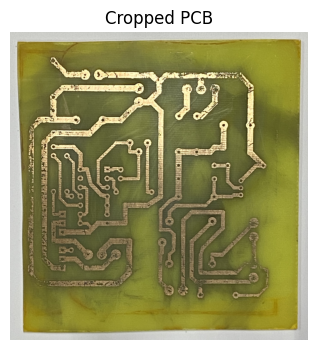

Loaded CNN checkpoint: /content/cnn_pcb_pipeline_best.pth
Loaded UNet checkpoint: /content/unet_pcb_pipeline_best.pth


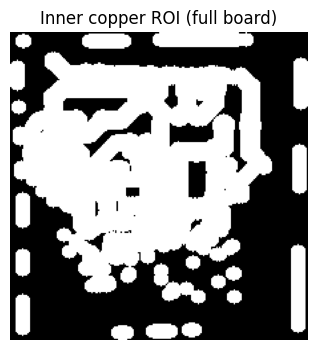

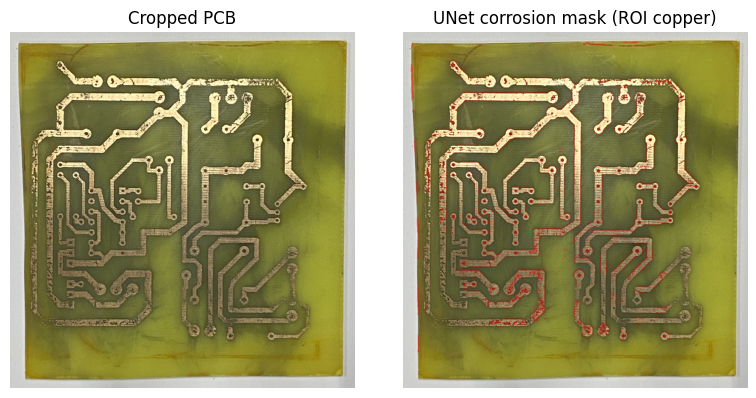

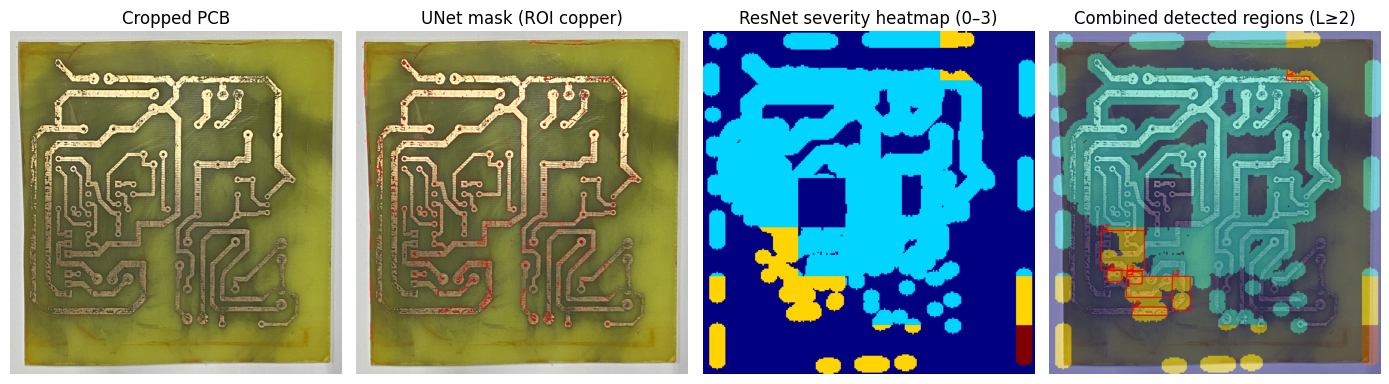


UNet corrosion coverage in copper ROI: 8.02%
Estimated global severity level (0–3) from UNet coverage: 3

Detected regions (ResNet+UNet, L≥2):
  #0: x=688, y=131, w=68, h=12, level=2
  #1: x=151, y=579, w=125, h=116, level=2
  #2: x=168, y=693, w=43, h=34, level=2
  #3: x=225, y=698, w=45, h=36, level=2
  #4: x=224, y=712, w=133, h=61, level=2
  #5: x=357, y=712, w=52, h=98, level=2
  #6: x=241, y=801, w=103, h=24, level=2


In [ ]:
#@title 14. Full inference: UNet tiled + ResNet severity (combined pipeline)

from google.colab import files
print("Upload a full PCB image...")
uploaded = files.upload()
full_img_path = list(uploaded.keys())[0]

full_bgr = cv2.imread(full_img_path)
if full_bgr is None:
    raise FileNotFoundError(full_img_path)

max_side = 1400
H0, W0 = full_bgr.shape[:2]
scale = min(max_side / max(H0, W0), 1.0)
if scale < 1.0:
    full_bgr = cv2.resize(full_bgr, (int(W0*scale), int(H0*scale)),
                          interpolation=cv2.INTER_AREA)

print("Original full image:", full_bgr.shape)

def crop_pcb_board(full_bgr, s_thresh=25):
    hsv_full = cv2.cvtColor(full_bgr, cv2.COLOR_BGR2HSV)
    S_full = hsv_full[:, :, 1]
    _, board_mask0 = cv2.threshold(S_full, s_thresh, 255, cv2.THRESH_BINARY)

    kernel_board = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    board_mask = cv2.morphologyEx(board_mask0, cv2.MORPH_CLOSE, kernel_board, iterations=1)
    board_mask = cv2.morphologyEx(board_mask, cv2.MORPH_OPEN,  kernel_board, iterations=1)

    contours, _ = cv2.findContours(board_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        print("WARNING: cannot find PCB board; using full image.")
        return full_bgr.copy(), 0, 0

    max_cnt = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(max_cnt)
    pad = int(0.02 * min(full_bgr.shape[0], full_bgr.shape[1]))
    x0 = max(x - pad, 0)
    y0 = max(y - pad, 0)
    x1 = min(x + w + pad, full_bgr.shape[1])
    y1 = min(y + h + pad, full_bgr.shape[0])
    board_bgr = full_bgr[y0:y1, x0:x1].copy()
    return board_bgr, x0, y0

board_bgr, x0, y0 = crop_pcb_board(full_bgr)
print("Cropped board shape:", board_bgr.shape)

plt.figure(figsize=(4,4))
plt.imshow(cv2.cvtColor(board_bgr, cv2.COLOR_BGR2RGB))
plt.title("Cropped PCB")
plt.axis("off")
plt.show()

cnn_ckpt = "/content/cnn_pcb_pipeline_best.pth"
if os.path.exists(cnn_ckpt):
    model_cnn.load_state_dict(torch.load(cnn_ckpt, map_location=device))
    print("Loaded CNN checkpoint:", cnn_ckpt)

unet_ckpt = "/content/unet_pcb_pipeline_best.pth"
if os.path.exists(unet_ckpt):
    model_unet.load_state_dict(torch.load(unet_ckpt, map_location=device))
    print("Loaded UNet checkpoint:", unet_ckpt)

model_cnn.to(device).eval()
model_unet.to(device).eval()

# Transforms cho inference (khớp với train)
cnn_infer_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
])
unet_infer_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5],
                         std =[0.5,0.5,0.5]),
])

H_board, W_board = board_bgr.shape[:2]
board_small = cv2.resize(board_bgr, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
_, inner_copper_small = pcb_corrosion_mask(board_small, debug=False)
inner_copper_full = cv2.resize(inner_copper_small,
                               (W_board, H_board),
                               interpolation=cv2.INTER_NEAREST).astype(np.uint8)

plt.figure(figsize=(4,4))
plt.imshow(inner_copper_full, cmap="gray")
plt.title("Inner copper ROI (full board)")
plt.axis("off")
plt.show()

def infer_unet_tiled(board_bgr,
                     model_unet,
                     img_size=224,
                     stride=112,
                     transform=None,
                     device=None,
                     thr=0.5):
    assert transform is not None
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    H, W = board_bgr.shape[:2]
    ys = list(range(0, max(H - img_size, 0) + 1, stride))
    xs = list(range(0, max(W - img_size, 0) + 1, stride))
    if len(ys) == 0: ys = [0]
    if len(xs) == 0: xs = [0]

    prob_map = np.zeros((H, W), dtype=np.float32)
    count_map = np.zeros((H, W), dtype=np.float32)

    model_unet.eval()
    model_unet.to(device)

    with torch.no_grad():
        for y in ys:
            for x in xs:
                patch = np.zeros((img_size, img_size, 3), dtype=np.uint8)
                sub = board_bgr[y:y+img_size, x:x+img_size]
                patch[:sub.shape[0], :sub.shape[1]] = sub

                patch_rgb = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
                patch_pil = Image.fromarray(patch_rgb)
                inp = transform(patch_pil).unsqueeze(0).to(device)

                logits = model_unet(inp)
                probs = torch.sigmoid(logits)[0, 0].cpu().numpy()

                h_sub, w_sub = sub.shape[:2]
                prob_map[y:y+h_sub, x:x+w_sub] += probs[:h_sub, :w_sub]
                count_map[y:y+h_sub, x:x+w_sub] += 1.0

    count_map[count_map == 0] = 1.0
    prob_map /= count_map
    mask_full = (prob_map > thr).astype(np.uint8)
    return prob_map, mask_full

prob_unet, mask_unet = infer_unet_tiled(
    board_bgr,
    model_unet=model_unet,
    img_size=IMG_SIZE,
    stride=IMG_SIZE//2,
    transform=unet_infer_transform,
    device=device,
    thr=0.5
)

mask_unet_roi = (mask_unet & (inner_copper_full > 0).astype(np.uint8)).astype(np.uint8)

overlay_unet = board_bgr.copy()
overlay_unet[mask_unet_roi == 1] = (0, 0, 255)
vis_unet = cv2.addWeighted(board_bgr, 0.6, overlay_unet, 0.4, 0)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(board_bgr, cv2.COLOR_BGR2RGB))
plt.title("Cropped PCB")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(vis_unet, cv2.COLOR_BGR2RGB))
plt.title("UNet corrosion mask (ROI copper)")
plt.axis("off")
plt.tight_layout()
plt.show()

def infer_resnet_heatmap_4ch_board(board_bgr,
                                   mask_unet_roi,
                                   patch_size=224,
                                   stride=112,
                                   resnet_model=None,
                                   transform=None,
                                   device=None,
                                   coverage_thr=0.01):

    assert resnet_model is not None and transform is not None
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    H, W = board_bgr.shape[:2]
    ys = list(range(0, max(H - patch_size, 0) + 1, stride))
    xs = list(range(0, max(W - patch_size, 0) + 1, stride))
    if len(ys) == 0: ys = [0]
    if len(xs) == 0: xs = [0]

    Gh = len(ys)
    Gw = len(xs)

    severity_grid = np.zeros((Gh, Gw), dtype=np.int32)
    prob_defect_grid = np.zeros((Gh, Gw), dtype=np.float32)

    resnet_model.eval()
    resnet_model.to(device)

    with torch.no_grad():
        for iy, y in enumerate(ys):
            for ix, x in enumerate(xs):
                h_sub = min(patch_size, H - y)
                w_sub = min(patch_size, W - x)

                patch_mask = mask_unet_roi[y:y+h_sub, x:x+w_sub]
                coverage = patch_mask.sum() / float(h_sub * w_sub)

                if coverage < coverage_thr:
                    severity_grid[iy, ix] = 0
                    prob_defect_grid[iy, ix] = 0.0
                    continue

                patch = np.zeros((patch_size, patch_size, 3), dtype=np.uint8)
                sub = board_bgr[y:y+patch_size, x:x+patch_size]
                patch[:sub.shape[0], :sub.shape[1]] = sub

                mask_clean01, _ = pcb_corrosion_mask(patch, debug=False)

                patch_rgb = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
                patch_pil = Image.fromarray(patch_rgb)
                img_3ch = transform(patch_pil)          # (3,H,W)
                mask_t = torch.from_numpy(mask_clean01).float().unsqueeze(0)
                inp_4ch = torch.cat([img_3ch, mask_t], dim=0).unsqueeze(0).to(device)

                logits = resnet_model(inp_4ch)
                proba = torch.softmax(logits, dim=1).cpu().numpy()[0]

                pred_cls = int(np.argmax(proba))
                p_defect = 1.0 - float(proba[0])

                severity_grid[iy, ix] = pred_cls
                prob_defect_grid[iy, ix] = p_defect

    return severity_grid, prob_defect_grid

severity_grid, prob_defect_grid = infer_resnet_heatmap_4ch_board(
    board_bgr,
    mask_unet_roi=mask_unet_roi,
    patch_size=IMG_SIZE,
    stride=IMG_SIZE//2,
    resnet_model=model_cnn,
    transform=cnn_infer_transform,
    device=device,
    coverage_thr=0.01
)

severity_map = cv2.resize(severity_grid.astype(np.float32),
                          (W_board, H_board),
                          interpolation=cv2.INTER_NEAREST)

severity_map[inner_copper_full == 0] = 0

severity_norm = severity_map / 3.0
heatmap_color = cv2.applyColorMap(
    (severity_norm * 255).astype(np.uint8),
    cv2.COLORMAP_JET
)
overlay_resnet = cv2.addWeighted(board_bgr, 0.6, heatmap_color, 0.4, 0)

min_severity_for_box = 2      
min_area_px = 500             
kernel_box = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))

mask_defect = ((severity_map >= min_severity_for_box) &
               (mask_unet_roi == 1)).astype(np.uint8)

mask_defect = cv2.morphologyEx(mask_defect, cv2.MORPH_CLOSE,
                               kernel_box, iterations=1)

num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(
    mask_defect, connectivity=8
)

vis_boxes = overlay_resnet.copy()
detected_regions = []

for label_id in range(1, num_labels):  
    x, y, w, h, area = stats[label_id]
    if area < min_area_px:
        continue

    region = severity_map[y:y+h, x:x+w]
    region_level = int(region.max())
    detected_regions.append((x, y, w, h, region_level))

    cv2.rectangle(vis_boxes, (x, y), (x+w, y+h), (0, 0, 255), 2)
    cv2.putText(vis_boxes, f"L{region_level}", (x, y-5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2)

plt.figure(figsize=(14,6))
plt.subplot(1,4,1)
plt.imshow(cv2.cvtColor(board_bgr, cv2.COLOR_BGR2RGB))
plt.title("Cropped PCB")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(cv2.cvtColor(vis_unet, cv2.COLOR_BGR2RGB))
plt.title("UNet mask (ROI copper)")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(heatmap_color[:, :, ::-1])
plt.title("ResNet severity heatmap (0–3)")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(cv2.cvtColor(vis_boxes, cv2.COLOR_BGR2RGB))
plt.title("Combined detected regions (L≥2)")
plt.axis("off")
plt.tight_layout()
plt.show()

cor_pix = int(mask_unet_roi.sum())
total_pix = int((inner_copper_full > 0).sum())
coverage = cor_pix / max(total_pix, 1)
print(f"\nUNet corrosion coverage in copper ROI: {coverage*100:.2f}%")

if coverage < 0.005:
    sev_global = 0
elif coverage < 0.02:
    sev_global = 1
elif coverage < 0.06:
    sev_global = 2
else:
    sev_global = 3
print("Estimated global severity level (0–3) from UNet coverage:", sev_global)

print("\nDetected regions (ResNet+UNet, L≥2):")
for i, (x, y, w, h, lvl) in enumerate(detected_regions):
    print(f"  #{i}: x={x}, y={y}, w={w}, h={h}, level={lvl}")

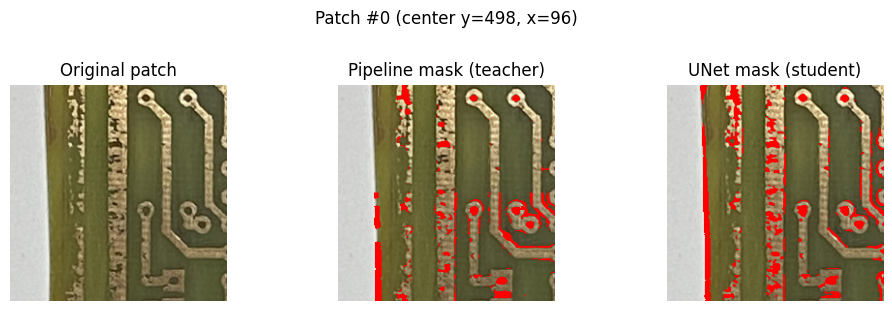

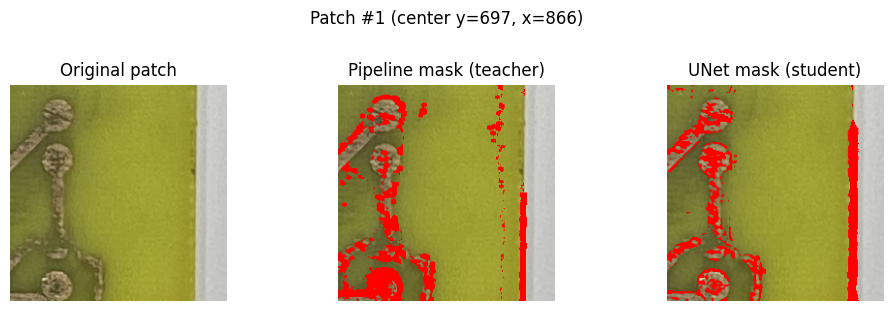

In [ ]:
#@title 15. Soi từng patch: pipeline vs UNet quanh vùng nghi ngờ

patch_size = IMG_SIZE          # 224
half = patch_size // 2

H_board, W_board = board_bgr.shape[:2]
patch_centers = [
    (int(0.5 * H_board), int(0.10 * W_board)), 
    (int(0.7 * H_board), int(0.90 * W_board)),  
]

model_unet.eval()

for idx, (cy, cx) in enumerate(patch_centers):
    y0 = max(0, cy - half)
    x0 = max(0, cx - half)
    y1 = min(H_board, y0 + patch_size)
    x1 = min(W_board, x0 + patch_size)
    y0 = max(0, y1 - patch_size)
    x0 = max(0, x1 - patch_size)

    patch_bgr = board_bgr[y0:y1, x0:x1].copy()

    patch_bgr_resz = cv2.resize(patch_bgr, (IMG_SIZE, IMG_SIZE),
                                interpolation=cv2.INTER_AREA)
    mask_teacher, _ = pcb_corrosion_mask(patch_bgr_resz, debug=False)  

    patch_rgb = cv2.cvtColor(patch_bgr_resz, cv2.COLOR_BGR2RGB)
    patch_pil = Image.fromarray(patch_rgb)
    inp = unet_infer_transform(patch_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model_unet(inp)
        probs = torch.sigmoid(logits)[0, 0].cpu().numpy()
    mask_unet_patch = (probs > 0.5).astype(np.uint8)
    
    vis_teacher = patch_bgr_resz.copy()
    vis_teacher[mask_teacher == 1] = (0, 0, 255)

    vis_unet = patch_bgr_resz.copy()
    vis_unet[mask_unet_patch == 1] = (0, 0, 255)

    plt.figure(figsize=(10,3))
    plt.suptitle(f"Patch #{idx} (center y={cy}, x={cx})", y=1.02)

    plt.subplot(1,3,1)
    plt.imshow(cv2.cvtColor(patch_bgr_resz, cv2.COLOR_BGR2RGB))
    plt.title("Original patch")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(cv2.cvtColor(vis_teacher, cv2.COLOR_BGR2RGB))
    plt.title("Pipeline mask (teacher)")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(cv2.cvtColor(vis_unet, cv2.COLOR_BGR2RGB))
    plt.title("UNet mask (student)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()